# Team Compositions in Professional League of Legends
***

The data being used was obtained from [Oracle's Elixer] (using upload from September 18th, 2017). A [codebook] for the variables is also included.

**Part 1: Data Cleaning** Can be found [here](http://nbviewer.jupyter.org/github/gmlander/Springboard/blob/master/Portfolio/Team_Composition_Analysis/I_Data_Cleaning.ipynb) or at the raw [github version](https://github.com/gmlander/Springboard/blob/master/Portfolio/Team_Composition_Analysis/I_Data_Cleaning.ipynb).

[Oracle's Elixer]: http://oracleselixir.com/match-data/
[codebook]: http://oracleselixir.com/match-data/match-data-dictionary/

---

# Part 2: Exploratory Data Analysis

#### Prepare Workspace and Get Data

The data being used was prepared in **Part 1**.

In [1]:
%%capture
# To keep these documents from getting untidy
# support_functions.py in this repo containts
# all necessary package imports and custom functions
from support_functions import *
%matplotlib inline

In [13]:
playerDF = unpickle('data/fill_players.pickle')
teamDF = unpickle('data/fill_team.pickle')

### Exploratory Data Analysis
***

Before getting into modeling and analysis decisions, it is important to get a sense correlations in the feature space. The heatmap of `teamDF`, suggests there are a lot of strongly correlated variables. This creates the possibility of multicolinearity and is important to note for modeling decisions later on. Either an algorithm robust to multicolinearity must be used, correlated features will need to be dropped/combined, or dimensionality reduction will have to be performed.

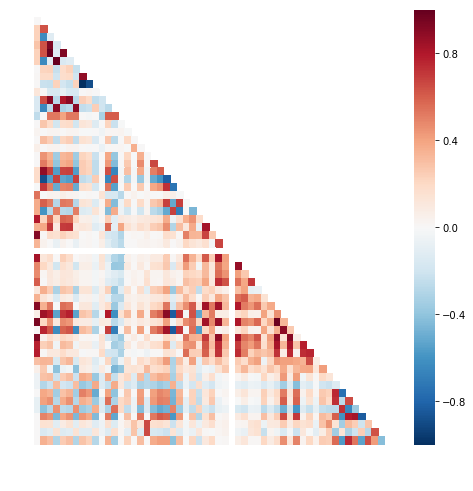

In [10]:
corr = teamDF.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (8,8))
plt.axis('off')
sns.heatmap(corr, mask = mask, cmap = 'RdBu_r')
plt.show()

Since ultimately the goal of this analysis will involve leveraging the data for insights that will improve a team's chances of winning, it would be useful to see which features are most strongly correlated (+/-) with `result`.

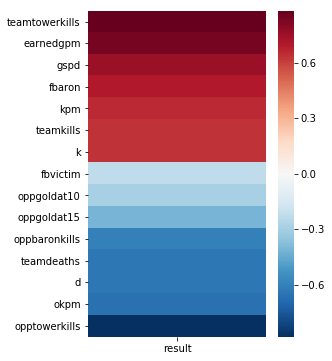

In [11]:
res_corr = corr.result.sort_values(ascending=False)[1:8]\
    .append(corr.result.sort_values()[7::-1])
plt.figure(figsize=(4, 6))
sns.heatmap(res_corr.to_frame(), cmap = 'RdBu_r')
plt.show()

Those correlations all make sense, and are going to be strong predictors of win/loss in any model. But those are all features a team has no preemptive control over. It may be more interesting to explore how pregame features impact result.

First areas to consider are team quality and playstyle. These things are not explicitly in the dataset, so they'll need to be derived. Win-rate and total games played will be added to each observation. There is another feature that proxies wins -  `gspd` - gold spent percent difference - this refers to how much more gold a team had spent relative to their opponent at the end of the game. Since gold acquisition strongly correlates with performance, this might be an interesting way to allow for regression predictions through 'weighted wins' later on. That way a model can be trained to predict not only victory and defeat, but close victory and close defeat. Call this feature `weighted_winRate` =  $winRate \times (avgGSPD + 1)$.

In [17]:
win_gspd = teamDF[['team','result','gspd']].groupby('team').mean()[['result', 'gspd']]
teamDF.loc[:,"winRate"] = teamDF["team"].map(win_gspd.result)
teamDF.loc[:,"avgGSPD"] = teamDF["team"].map(win_gspd.gspd)
teamDF['weighted_winRate'] = teamDF.winRate * (teamDF.avgGSPD + 1)

for k in playerDF:
    playerDF[k].loc[:,"teamWinRate"] = playerDF[k]["team"].map(win_gspd.result)

teamDF.loc[:,'totalGames'] = teamDF.team.map(teamDF.team.value_counts())
for k in playerDF:
    playerDF[k].loc[:,'totalGames'] = teamDF.player.map(playerDF[k].player.value_counts())

**Additional Feature Creation**  
> For teamDF

- *quality* -- A quintile cut of `winRate`, bounded by 'Bad', 'Poor', 'Average', 'Good', 'Great'.
- *weighted_quality* -- A quintile cut of `weighted_winRate`, bounded by 'Bad', 'Poor', 'Average', 'Good', 'Great'.

In [28]:
teamDF['quality'] = pd.qcut(teamDF['winRate'],
                            q = 5, labels =  ['Bad', 'Poor', 'Average', 'Good', 'Great'])
teamDF['weighted_quality'] = pd.qcut(teamDF['weighted_winRate'],
                                     q = 5, labels =  ['Bad', 'Poor', 'Average', 'Good', 'Great'])

**Feature Creation (cont'd)**
- *pace* -- A quintile cut of `gamelength`, bounded by 'Very Fast', 'Fast', 'Average', 'Slow', 'Very Slow'.
- *aggression* -- A quintile cut of `ckpm` (combined kills per minute), bounded by 'Very Controlled', 'Controlled' ,'Average', 'Aggressive', 'Very Aggressive'.

**Note**: This will use a version of teamDF from part 1, that was standard scaled with observations grouped patch #. This is important because the meta of the game changes (sometimes drastically from patch to patch). Creating the binned features from data scaled in such a way ensures a proper apples-to-apples comparison. This wasn't necessary in the previous step because those features (wins, gspd, game count) are invariate with patch number.

In [18]:
scale_teamDF = unpickle('data/scaled_teams.pickle')

In [35]:
teamDF['pace'] = pd.qcut(scale_teamDF['gamelength'],
             q=5, labels = ['Very Fast', 'Fast', 'Average', 'Slow', 'Very Slow'])
teamDF['aggression'] = pd.qcut(scale_teamDF['ckpm'],
    q=5, labels = ['Very Controlled', 'Controlled' ,'Average', 'Aggressive', 'Very Aggressive'])

Now that I've derived these additional columns, I can explore how they relate to one another.

A quick peak at whether weighted_quality was any different from quality shows that most teams are binned the same either way, but some 'Average' teams are better than their records appear, and some 'Good' teams are worse.

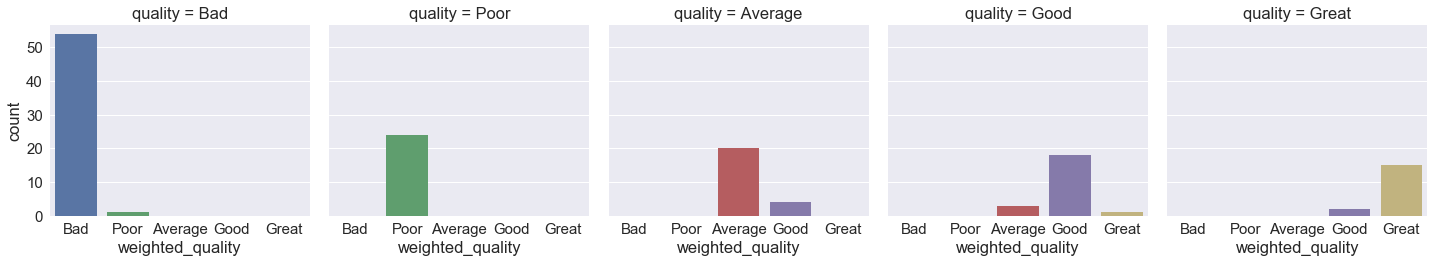

In [50]:
sns.set(font_scale=1.5)
ay = sns.factorplot( x="weighted_quality", col = 'quality',
            data=teamDF[['weighted_quality', 'team', 'quality']].drop_duplicates(),
            kind = 'count')

### Visualizing Effects of Pace on Wins

Looking at how successful teams play, it appears they win faster and lose slower. So the opposite of traditional sports strategy of raising pace to raise variance holds. Slow games give bad teams a chance to win the game off a single late-game team fight.

**Note**: In all of these visualizations, the counts will be highest for bad teams as there are more bad teams in the dataset. Bad teams come and go, good teams persist and there are only so many wins to go around.

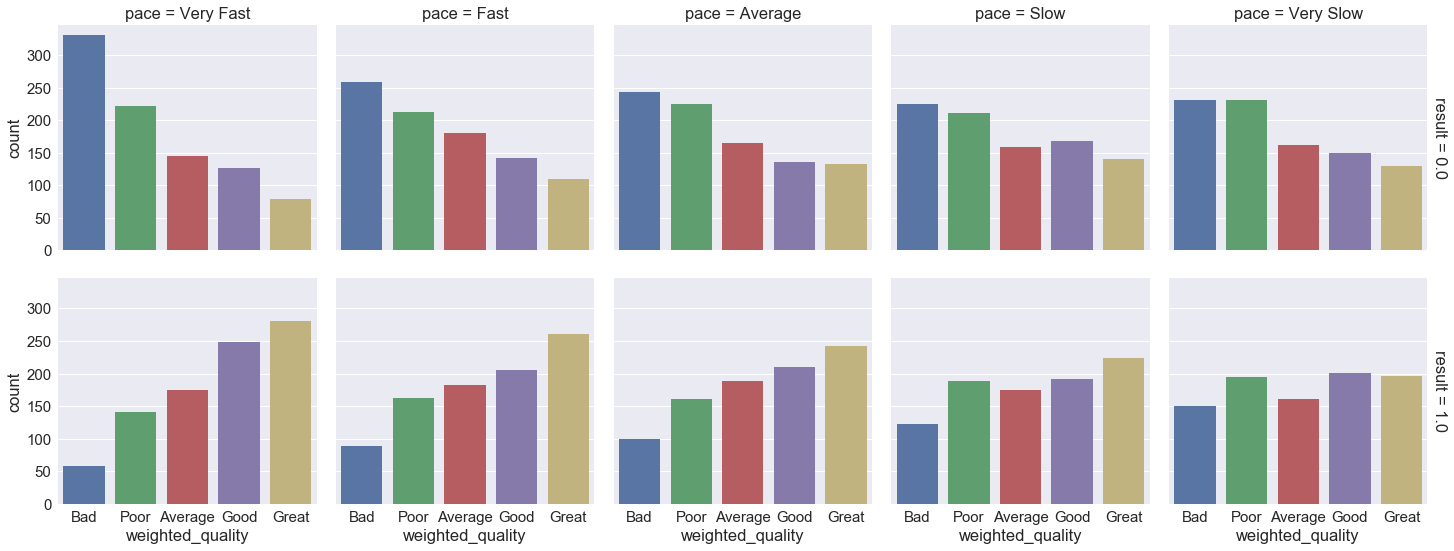

In [64]:
ay = sns.factorplot( col="pace", x = 'weighted_quality',
                    row = 'result', data=teamDF,
                    kind = 'count', margin_titles = True)

**vs. 'Great' Teams**:

It would also help to see how teams succeed and fail when they're up against the best competition. The same inverse relationship between pace and team quality for chance of winning holds up (though not as pronounced).

In [61]:
great_games = teamDF[teamDF.weighted_quality == 'Great'].gameid
vs_great_DF = teamDF[teamDF['gameid'].isin(great_games)]
vs_great_DF = vs_great_DF[vs_great_DF.weighted_quality != 'Great']

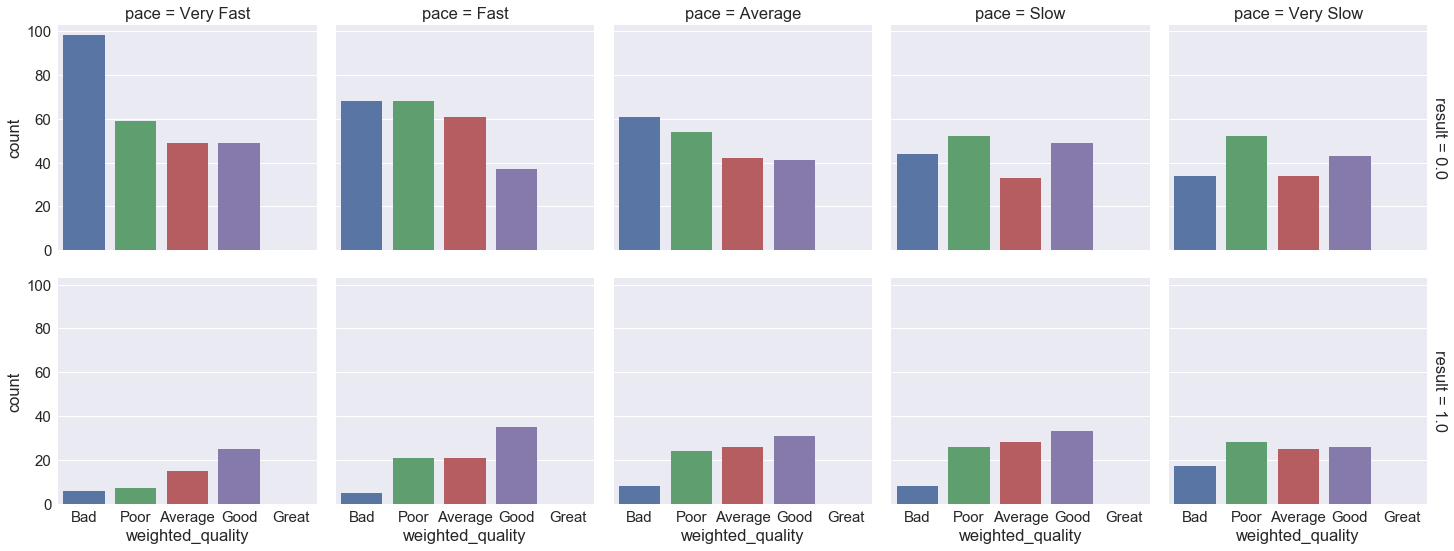

In [63]:
ay = sns.factorplot( col="pace", x = 'weighted_quality', row = 'result',
                   data=vs_great_DF, kind = 'count', margin_titles = True)

---

### Visualizing Effects of Aggression on Wins

Like lowering tempo, lowering pace also improves a bad team's chances of winning. The opposite is again true for better teams, but to a lesser extent, as great teams appear to fair slightly better in games with a mild amount of aggression.

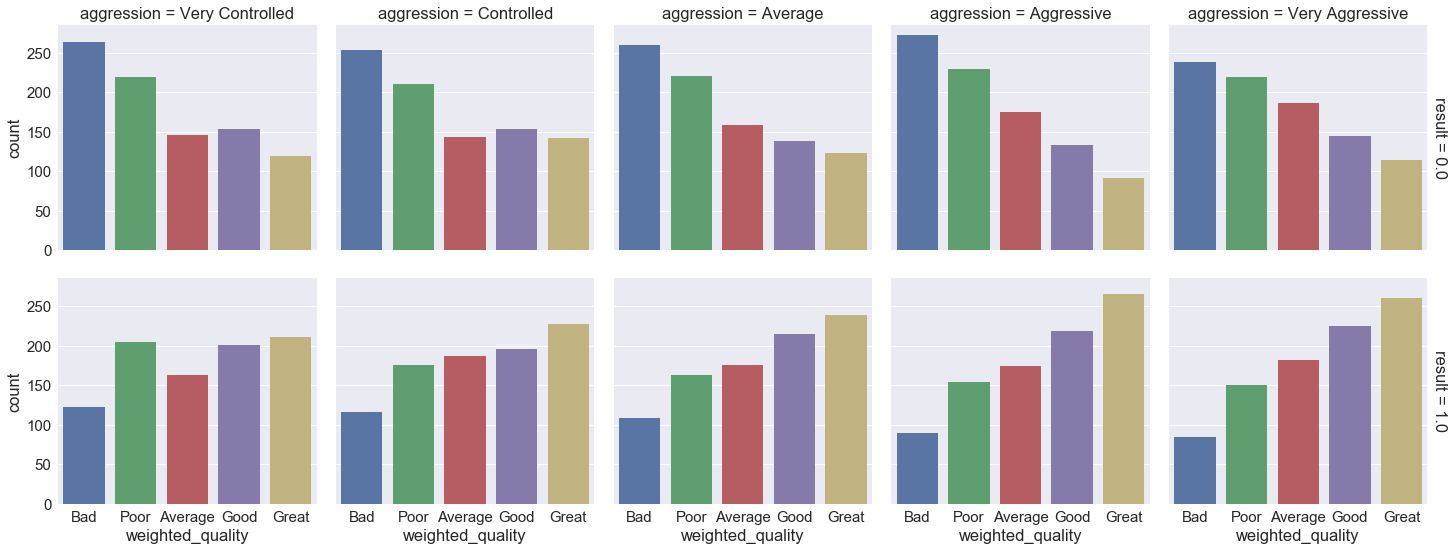

In [52]:
ay = sns.factorplot( col="aggression", x = 'weighted_quality',
                    row = 'result', data=teamDF,
                    kind = 'count', margin_titles = True)

**vs. 'Great' Teams**:

Interesting. Here the opposite holds for bad teams, as they start becoming more likely to beat great teams very aggressive games. Good teams fair best with average or slightly conservative levels of aggression.

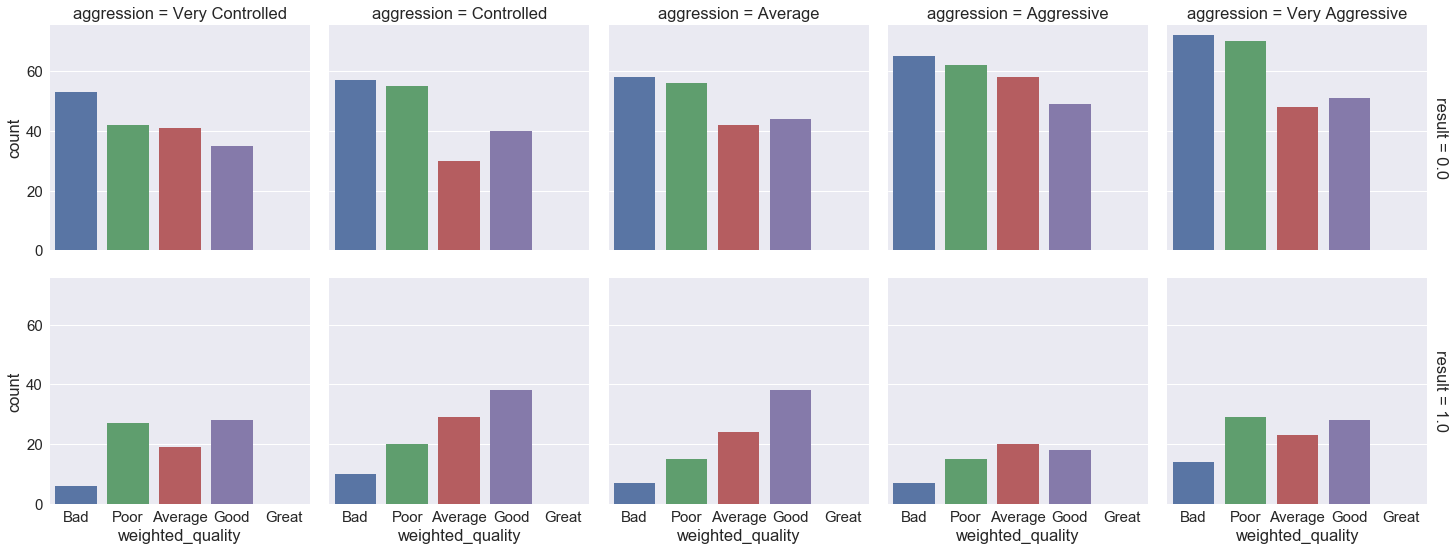

In [62]:
ay = sns.factorplot( col="aggression", x = 'weighted_quality', row = 'result',
                    data=vs_great_DF, kind = 'count', margin_titles = True)

### Digging Deeper

Another possible reason bad teams are able to find success against good teams when they raise the pace of the game is by sneaking baron. Looking at games against great teams where the lesser team was behind in gold @15 minutes and took first baron, it's clear that when low quality teams beat great teams, it's because they were able to to take sneak/rush the baron (units are patch-scaled times).

Whenever the lesser team was able to take baron early, even in games they were loosing, it greatly improved their chances of winning. This applied to the good and average teams as well, but to a lesser degree.

Number of games being plotted:  204


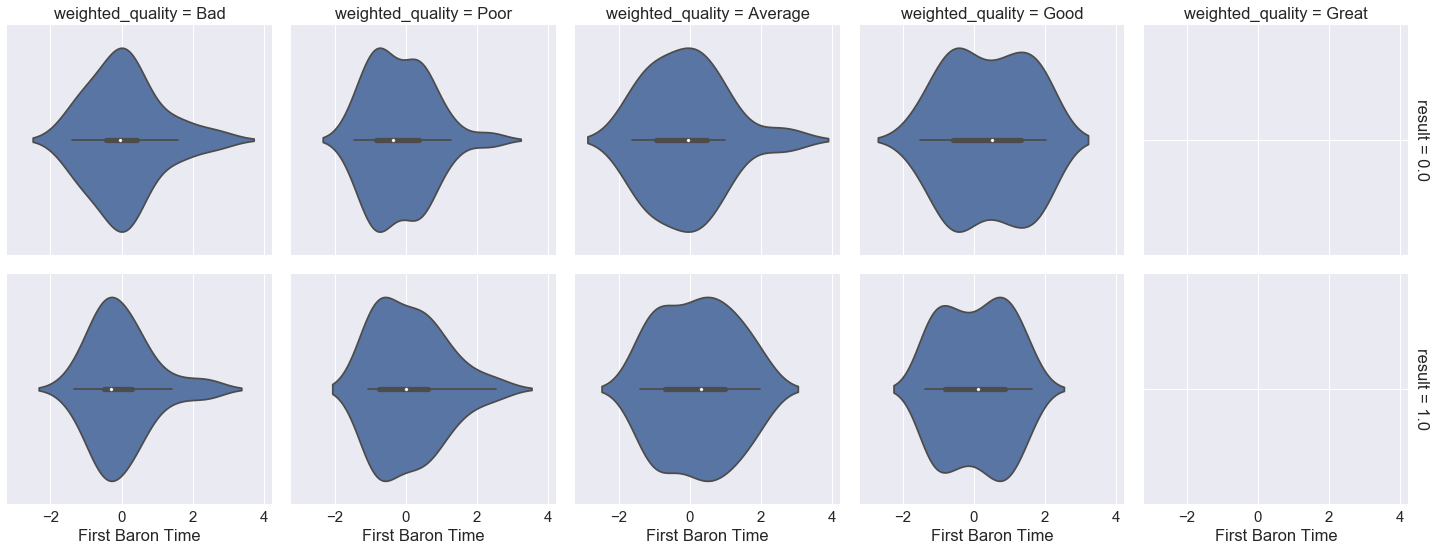

In [82]:
sneak_baron = (vs_great_DF.fbaron == 1) & (vs_great_DF.gdat15 < 0)
ay = sns.factorplot( x="First Baron Time", col = 'weighted_quality', row = 'result',
                   data=vs_great_DF[sneak_baron], kind = 'violin',
                   margin_titles = True);
print('Number of games being plotted: ',vs_great_DF[sneak_baron].shape[0])

Looking a little closer, this visual observation is confirmed statistically by both a standard t-test and a Welch's t-test for unequal variance for all but the most conservative of $\alpha$'s. Lesser teams have a higher win rate (by 3.5+ units of s.d.) in games they are losing to top competition when they sneak/rush barons.

In [96]:
t_test = partial(stats.ttest_ind, a = vs_great_DF[(vs_great_DF.fbaron == 1) & \
    (vs_great_DF.gdat15 < 0) & (vs_great_DF['First Baron Time'] < 0) & \
    (vs_great_DF.weighted_quality < 'Average')].result,
      b = vs_great_DF[vs_great_DF.weighted_quality < 'Average'].result)
print('Equal Variance t-Test:', t_test())
print('Unequal Variance t-Test:', t_test(equal_var = False))

Equal Variance t-Test: Ttest_indResult(statistic=4.3020422997630545, pvalue=1.9049977036436463e-05)
Unequal Variance t-Test: Ttest_indResult(statistic=3.5382309281599538, pvalue=0.00084393693868012212)


### Map Side

Beyond playstyle decisons and champion selections (which will be dealt with in great detail in the coming sections) there is one other major pregame feature -- map side. A quick glance to see if this has an effect on result.

In [97]:
print(teamDF[['result']].groupby(teamDF['side']).mean())

       result
side         
Blue  0.55255
Red   0.44745


There definitely appears to be an effect. 2 sample t-test with significance at 95% confidence ( $ \alpha = 0.05 $) confirms this quite emphatically.

In [115]:
print(stats.ttest_ind(teamDF[teamDF.side == 'Blue'].result,
                teamDF[teamDF.side == 'Red'].result))

Ttest_indResult(statistic=10.036189699364618, pvalue=1.4048532685384954e-23)


In the great battle of red vs blue, blue wins!

With such a strong effect from starting side, there more questions than answers. Why does starting side act as such a strong determinant in outcome? With some domain knowledge of the game, there are a two strong possibilities to explain this:

- Blue side gets first champion pick and has more influence over the draft and/or the ability to pick up the most powerful champion to slip through bans.
- Map layout has certain advantages in terms of baron control that favor blue.

So the real question is - Does blue win often because of an in-game advantages or pre-game advantages?

Another strongly correlated feature with `result` was 'fb' (First Blood). This column is marked with a one for teams that drew first blood, and a zero otherwise. Since first blood generally occurs before dragon and baron control have influenced the game, it might be a good place to look towards an answer. If the blue side is outperforming the red side in first blood, it would not be unreasonable to think that their advantage is coming from picks and bans.

In [100]:
print(teamDF[['fb']].groupby(teamDF['side']).mean())

            fb
side          
Blue  0.522395
Red   0.477605


Indeed, blue side appears to draw first blood more often than red, and this can again be confirmed by a t-test with $\alpha = 0.05$.

In [102]:
print(stats.ttest_ind(teamDF[teamDF.side == 'Blue'].fb,
                      teamDF[teamDF.side == 'Red'].fb))

Ttest_indResult(statistic=4.2576111713038545, pvalue=2.0871668499679977e-05)


It would appear blue side gains its advantage from pregame factors. It's curious though why the game developers would allow such an imbalance to persist. Perhaps it's worth looking at this effect over each patch.

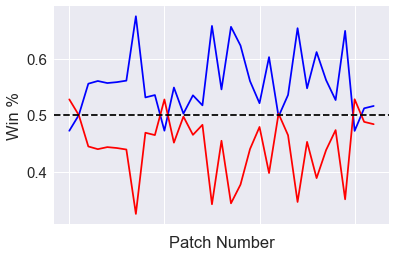

In [107]:
patch_side = teamDF.groupby(['patchno','side'])['result'].mean().unstack()
_ = patch_side['Blue'].plot(color = 'blue')
_ = patch_side['Red'].plot(color = 'red')
_ = plt.xlabel('Patch Number')
_ = plt.ylabel('Win %')
plt.axhline(y=.5, ls = 'dashed', color = 'black')
plt.show()

It definitely appears that blue side has held the advantage for most iterations of the game. However, not every patch has the same number of games in it, and looking for statistical significance of side wins by patch (with multiple hypothesis testing using a holm-sidak correction), shows a very different story than the graph.

In [134]:
pvals = []
for p, df in teamDF.groupby('patchno'):
    pvals.append(stats.ttest_ind(df[df.side == 'Blue'].result,
                                 df[df.side == 'Red'].result).pvalue)
print('Freqeuncy of signficiant advantage for blue side: {:0.2f}%'\
      .format(100*sum(multipletests(pvals=pvals, alpha=0.05)[0]) / len(pvals)))

Freqeuncy of signficiant advantage for blue side: 18.18%


## Baseline Modeling

The last key part of this exploratory data analysis will be to build a simple, baseline model for comparison. Since the goal is predicting wins vs losses, the simple model will be a logistic regression. Before modeling however, there's that observation from the heatmap earlier of potential multicolinearity.

There will definitely be a lot of correlation going on between gamelength related variables (ie, longer games generally mean more kills, more minionkills, more deaths, more gold, etc). Because this correlation between IV's can be more than merely pairwise, they'll need to be evaluated by Variance Inflation Factor (V.I.F).

In [155]:
%%capture --no-stdout
print(get_vif(teamDF).head(10))

             Variance Inflation Factor
Regressor                             
oppgoldat15                        inf
fbvictim                           inf
gdat10                             inf
goldat15                           inf
gdat15                             inf
ckpm                               inf
okpm                               inf
kpm                                inf
goldat10                           inf
oppgoldat10                        inf


The concern of multicolinearity in the data is definitely confirmed by the infinite value VIF's. Considering the math behind VIF's:

<center>$$ VIF_k=\frac{1}{1-R_{k}^{2}} $$</center>

Where $R_{k}^{2}$ is the $R^{2}$ obtained from performing a regression on the k<sup>th</sup> IV using all other remaining IV's. This means the more correlated an IV is with the other IV's, the higher it's VIF value will be.

Infinite values here require an $R^2$ of 1, which means some IV's can be perfectly derived from others, an easy example seen above is $goldat10 - oppgoldat10 = gdat10$.

Through rerunning VIF testing several times with a lot of trial, error, deductive reasoning and more error - the features responsible for the infinite and extreme VIF values are: ['k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills', 'totalgold', 'gamelength', 'dmgtochamps', 'teamkills', 'teamdeaths', 'wardkills', 'monsterkills', 'winRate','earnedgpm']

**Note**: Other features could have been chosen to this end, but this set minimized the number in the list while seeming sensible.

Removing these features and running VIF testing again reveals...

In [156]:
%%capture --no-stdout
drops = ['k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10',
         'wards', 'minionkills', 'totalgold','gamelength', 'dmgtochamps',
         'teamkills', 'teamdeaths', 'wardkills', 'monsterkills','winRate','earnedgpm']
print(get_vif(teamDF, drops = drops).head())

                  Variance Inflation Factor
Regressor                                  
goldspent                            12.840
weighted_winRate                      8.765
avgGSPD                               8.666
kpm                                   8.566
gspd                                  8.314


Not perfect, but a big improvement from where it started. All but one VIF's are below 10, which is the target level.

### Logistic Regression

A quick check shows a high level of prediction accuracy is achievable right away, with or without the VIF features.

In [178]:
lr = LogisticRegression()
X = teamDF.select_dtypes(exclude=['object','category']).drop('result',axis=1)
Xv_train, Xv_test, yv_train, yv_test = \
                train_test_split(scale(X.drop(drops, axis=1,errors = 'ignore')),
                                 teamDF.result, test_size = .25, random_state=10)
pred = lr.fit(Xv_train, yv_train).predict(Xv_test)

print('Prediction Accuracy without VIF features: {:0.2f}%'.format(100*accuracy_score(y_test, pred)))

X_train, X_test, y_train, y_test = train_test_split(scale(X), teamDF.result,
                                                    test_size = .25, random_state=10)
lr = LogisticRegression()
pred = lr.fit(X_train, y_train).predict(X_test)

print('Prediction Accuracy with VIFs: {:0.2f}%'.format(100*accuracy_score(y_test, pred)))

Prediction Accuracy without VIF features: 98.94%
Prediction Accuracy with VIFs: 98.94%


The model was extremely successful in predicting wins and losses. However, it was provided with features that contained a mix of in-game and pre-game information. Since the goal of this analysis is to determine pre-game strategies teams can apply to increase their chances of winning, it would be great to make the model as independent of in-game information as possible.

Let's start by looking at the coefficients our model produced, and seeing which features had the strongest effect.

**Note** The actual coefficients have been transformed into more easily interpretable odds ratios. Note that each of these odds ratios represents the change in probability of a win for a 1 unit increase in its respective predictor with all other predictors held constant. Also, the data given to the predictor was standard scaled, so a 1 unit increase means 1 standard deviation.

In [172]:
ecfs = sorted(zip(np.exp(lr.coef_[0]) - [1]*len(lr.coef_[0]), X.columns.tolist()))
print("Strongest negative effects: ", *ecfs[:5], sep ='\n')
print("\n Strongest positive effects: ", *ecfs[-5:][::-1], sep='\n')
print("\n Intercept: ", np.exp(lr.intercept_[0]))

Strongest negative effects: 
(-0.97512565173628896, 'opptowerkills')
(-0.89946597100290615, 'gspd')
(-0.82016254334202887, 'goldspent')
(-0.46471886952467811, 'okpm')
(-0.45767366393073405, 'd')

 Strongest positive effects: 
(35.859273858851125, 'teamtowerkills')
(4.8374215513978953, 'earnedgpm')
(1.415971444096495, 'a')
(1.0617405243543159, 'totalgold')
(1.0343802136116378, 'minionkills')

 Intercept:  0.855874841957


**Quick Insights:**
***
- Tower kills are the strongest determinants.
- A death is more damaging than a kill is beneficial, so 'trade' kills are not recommended.
- Gold spent has a negative effect but gold earned is positive. Because this regression is without the VIF's dropped, there's a balancing act occuring for the colinearity.

Looking at the effects with VIF's removed:

In [180]:
lr = LogisticRegression().fit(Xv_train, yv_train)
ecfs = sorted(zip(np.exp(lr.coef_[0]) - [1]*len(lr.coef_[0]), X.columns.drop(drops).tolist()))
print("Strongest negative effects: ", *ecfs[:5], sep ='\n')
print("\n Strongest positive effects: ", *ecfs[-5:][::-1], sep='\n')
print("\n Intercept: ", np.exp(lr.intercept_[0]))

Strongest negative effects: 
(-0.97338875805010094, 'opptowerkills')
(-0.91466954800638423, 'gspd')
(-0.88541748389033947, 'okpm')
(-0.4758343634005725, 'goldspent')
(-0.33108522519603756, 'fbassist')

 Strongest positive effects: 
(60.629576958562424, 'teamtowerkills')
(4.7226206972294564, 'kpm')
(1.8683814951219175, 'cspm')
(1.5240200536170958, 'a')
(0.52815548870488227, 'monsterkillsownjungle')

 Intercept:  0.862521383298


It's odd that goldspent still has a negative effect (though it has gone down quite a bit), but it was the highest VIF inflater remaining, so it must be balancing some other features further down the positive effects list.

---

** Expand Categorical Features**

In order to eventually create the necessary dummy variables to build the logit model from categorical **and** numeric data, champion selections from playerDF need to be added to teamDF.

In [184]:
teamDF.set_index(['gameid','team'], inplace=True)
for k, df in playerDF.items():
    teamDF[k] = df.set_index(['gameid','team']).champion

Now to test a regression without any in-game information. This will probably not be 99% accurate like the last one.

In [197]:
pre_feats = ['side', 'ban1','ban2', 'ban3', 'ban4', 'ban5','totalGames',
             'avgGSPD', 'weighted_winRate','weighted_quality', 'pace',
             'aggression', 'Top', 'Jungle', 'Middle','ADC', 'Support']

lr = LogisticRegression()
X = pd.get_dummies(teamDF[pre_feats])
X_train, X_test, y_train, y_test = train_test_split(scale(X),teamDF.result,
                                        test_size = .25, random_state=10)
pred = lr.fit(X_train, y_train).predict(X_test)
print('Prediction Accuracy with only pre-game features: {:0.2f}%'.format(100*accuracy_score(y_test, pred)))

Prediction Accuracy with only pre-game features: 58.18%


Better than a coin flip! But not by enough to really get excited about. Looking at the odds ratios of the coefficients...

In [198]:
ecfs = sorted(zip(np.exp(lr.coef_[0]) - [1]*len(lr.coef_[0]), X.columns.tolist()))
print("Strongest negative effects: ", *ecfs[:5], sep ='\n')
print("\n Strongest positive effects: ", *ecfs[-5:][::-1], sep='\n')
print("\n Intercept: ", np.exp(lr.intercept_[0]))

Strongest negative effects: 
(-0.19556724668156955, 'Middle_Yasuo')
(-0.16951012001764709, 'ban1_Nautilus')
(-0.16191096064065325, 'ban2_Nunu')
(-0.15166074275087149, 'ban1_Lux')
(-0.1474463380624752, 'ban3_Ahri')

 Strongest positive effects: 
(1.1411005154394891, 'weighted_winRate')
(0.27669617836334415, 'ban2_Lux')
(0.22070799979479583, 'Top_Pantheon')
(0.21347424539737059, 'ban1_Vladimir')
(0.20851088311211119, 'ban4_Singed')

 Intercept:  1.03022363143


Not only is this model way worse, but its odds ratios are pretty much completely uninterprettable, based only on a couple of  small sample size or meta specific events. It will probably get even worse if weighted win rate and quality are removed to represent more of a true blind prediction...

In [199]:
lr = LogisticRegression()
X = pd.get_dummies(teamDF[pre_feats].drop(['weighted_winRate',
                                   'weighted_quality','avgGSPD'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(scale(X),teamDF.result,
                                        test_size = .25, random_state=10)
pred = lr.fit(X_train, y_train).predict(X_test)
print('Prediction Accuracy without in-game or team quality features:\
{:0.2f}%'.format(100*accuracy_score(y_test, pred)))

Prediction Accuracy without in-game or team quality features:56.05%


Still better than a coin. But not by much. The following sections will deal with feature engineering ways to improve this predictive power without using in-game specific information.

In [200]:
enpickle(teamDF, 'data/eda_teamDF.pickle')
enpickle(playerDF, 'data/eda_playerDF.pickle')